# NeuralNibbles: Automated Detection of Pizza, Steak, and Sushi using Deep Learning

## Importing required libraries

In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.4/209.4 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 797.1/797.1 MB 849.7 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 108.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 78.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 52.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

torch version: 2.4.0+cu121
torchvision version: 0.19.0+cu121


In [1]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

In [2]:
!pip install efficientnet_pytorch

In [3]:
import requests
import zipfile
from pathlib import Path
import random
from PIL import Image
from torch import nn
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision import transforms
import torchvision.models as models
from efficientnet_pytorch import EfficientNet

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Importing the Dataset from the Github

In [5]:
# Setup path to a path folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image doesn't exist
if image_path.is_dir():
  print(f"{image_path} directory already exists... skipping download")
else:
  print(f"{image_path} does not exist, creating one...")
  image_path.mkdir(parents=True, exist_ok=True)

# Download pizza, steak and sushi data
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("Downloading pizza, steak, sushi data...")
  f.write(request.content)

# Unzip pizza, steak, sushi
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
  print("Unzipping pizza, steak and sushi data....")
  zip_ref.extractall(image_path)

data/pizza_steak_sushi directory already exists... skipping download
Unzipping pizza, steak and sushi data....


In [6]:
def walk_through_dir(dir_path):
  """Walks through dir_path returning its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [7]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

## Visualization of the Image

Random image path: data/pizza_steak_sushi/test/sushi/2715127.jpg
Image class: sushi
Image height: 512
Image width: 512


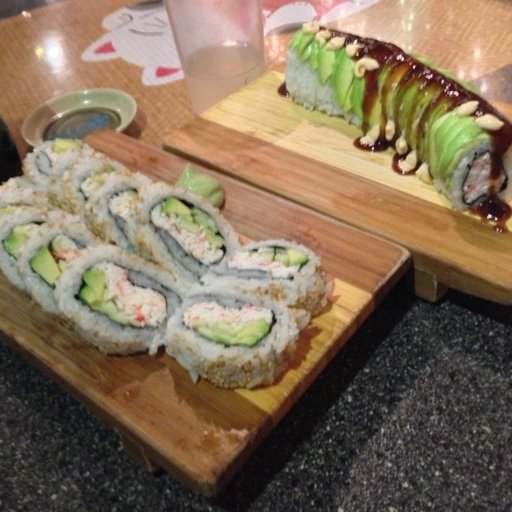

In [8]:
# Set seed
random.seed(42)

# Get all the image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# Pick a random image path
random_image_path = random.choice(image_path_list)

# Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# Open image
img = Image.open(random_image_path)

# print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

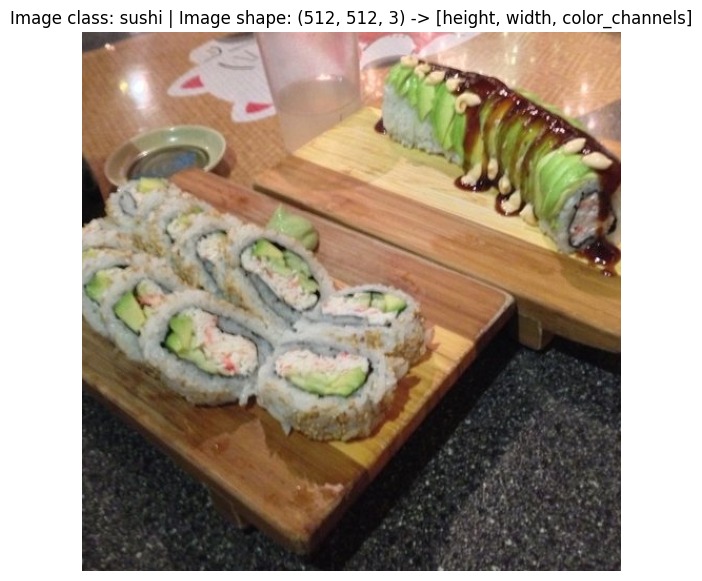

In [9]:
# Visualize and image using matplotlib

# turn the image into as array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

In [10]:
img_as_array.shape

(512, 512, 3)

## Augmentation Transform

In [11]:
# Create training transform with TrivialAugmentation
train_transform_trivial = transforms.Compose([
    transforms.Resize(size=(255,255)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform_simple = transforms.Compose([
    transforms.Resize(size=(255,255)),
    transforms.ToTensor()
])

In [12]:
train_transform_trivial(img)

tensor([[[0.3176, 0.3098, 0.3098,  ..., 0.5882, 0.5725, 0.5686],
         [0.0000, 0.3020, 0.2980,  ..., 0.6353, 0.6275, 0.6353],
         [0.0000, 0.2941, 0.2980,  ..., 0.6941, 0.6863, 0.6863],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.1412, 0.1490, 0.1529],
         [0.0000, 0.0000, 0.0000,  ..., 0.1176, 0.1216, 0.1176],
         [0.0000, 0.0000, 0.0000,  ..., 0.1686, 0.1490, 0.1490]],

        [[0.2706, 0.2667, 0.2706,  ..., 0.4392, 0.4275, 0.4275],
         [0.0000, 0.2627, 0.2627,  ..., 0.4745, 0.4706, 0.4784],
         [0.0000, 0.2627, 0.2706,  ..., 0.5176, 0.5176, 0.5176],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.1373, 0.1490, 0.1529],
         [0.0000, 0.0000, 0.0000,  ..., 0.1176, 0.1216, 0.1176],
         [0.0000, 0.0000, 0.0000,  ..., 0.1647, 0.1451, 0.1490]],

        [[0.2745, 0.2706, 0.2667,  ..., 0.3255, 0.3098, 0.3020],
         [0.0000, 0.2588, 0.2588,  ..., 0.3529, 0.3490, 0.3569],
         [0.0000, 0.2510, 0.2549,  ..., 0.3961, 0.3922, 0.

In [13]:
print(train_transform_trivial(img).shape)
print(train_transform_trivial(img).dtype)

torch.Size([3, 255, 255])
torch.float32


## Visualization of Image after Transformation

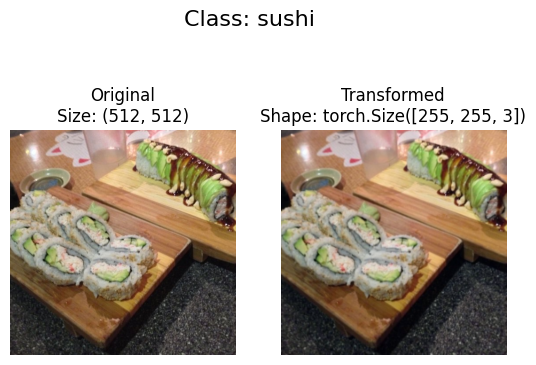

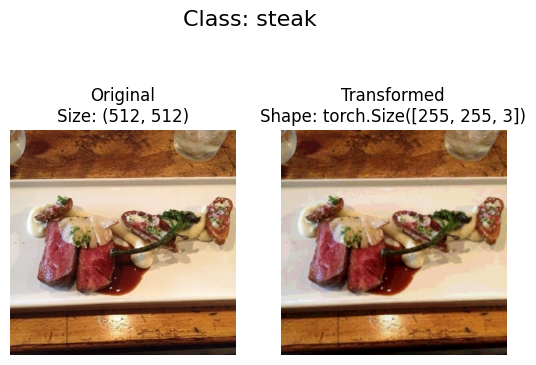

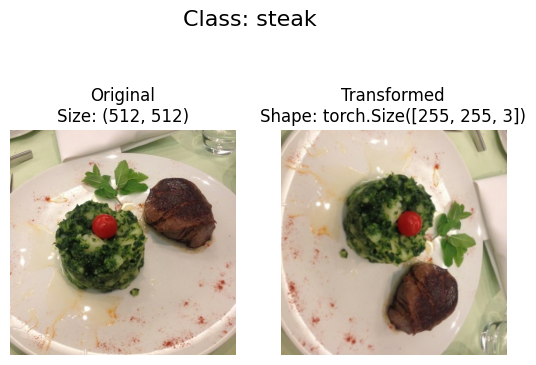

In [14]:
def plot_transformed_images(image_paths: list, transform, n=3, seed=None):
  """ Select random images from a path of images and loads/transforms
  them then plots the original vs the transformed version."""
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)

      # Transform ad plot target image
      transformed_image = transform(f).permute(1, 2, 0) # note we will need to change shape for matplotlib
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_paths=image_path_list,
                        transform=train_transform_trivial,
                        n=3, seed=42)

In [15]:
# create train and test dataset's and dataloader's with data augmentation
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=train_transform_trivial)
test_data = datasets.ImageFolder(root=test_dir,
                                transform=test_transform_simple)

In [16]:
# Get class names as list
class_names=train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [17]:

# Get class names as dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [18]:
# Index on the train_data dataset to get a single image and label
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n {img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
 tensor([[[0.1176, 0.1176, 0.1176,  ..., 0.1294, 0.1176, 0.1176],
         [0.1216, 0.1255, 0.1216,  ..., 0.1176, 0.1176, 0.1216],
         [0.1255, 0.1294, 0.1255,  ..., 0.1176, 0.1216, 0.1176],
         ...,
         [0.1647, 0.1608, 0.1647,  ..., 0.0824, 0.0863, 0.0902],
         [0.1529, 0.1569, 0.1490,  ..., 0.0863, 0.0863, 0.0863],
         [0.1412, 0.1412, 0.1412,  ..., 0.0745, 0.0824, 0.0824]],

        [[0.0510, 0.0510, 0.0510,  ..., 0.0745, 0.0627, 0.0627],
         [0.0549, 0.0588, 0.0549,  ..., 0.0627, 0.0627, 0.0667],
         [0.0588, 0.0627, 0.0588,  ..., 0.0627, 0.0667, 0.0627],
         ...,
         [0.2353, 0.2353, 0.2392,  ..., 0.1020, 0.1059, 0.1098],
         [0.2314, 0.2353, 0.2275,  ..., 0.1059, 0.1059, 0.1059],
         [0.2275, 0.2275, 0.2275,  ..., 0.0941, 0.1020, 0.1020]],

        [[0.0039, 0.0039, 0.0039,  ..., 0.1059, 0.0941, 0.0941],
         [0.0078, 0.0078, 0.0078,  ..., 0.0941, 0.0941, 0.0980],
         [0.0039, 0.0078, 0.0039,  ..., 0.0

## Changing the order of Dimension of the Image

Original shape: torch.Size([3, 255, 255]) -> [color_channels, height, width]
Image permute: torch.Size([255, 255, 3]) -> [height, width, color_channels]


Text(0.5, 1.0, 'pizza')

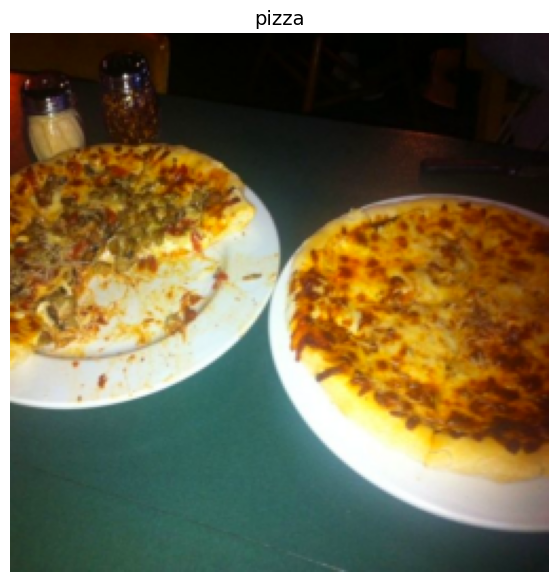

In [19]:
# Rearrange the order dimensions
img_permute = img.permute(1, 2, 0)

# Print out difference shapes
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute: {img_permute.shape} -> [height, width, color_channels]")

plt.figure(figsize=(10, 7))
plt.imshow(img_permute)
plt.axis("off")
plt.title(class_names[label], fontsize=14)

## Dataloader

In [20]:
# Turn datasets into dataloader
import os
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
from torch.utils.data import DataLoader
torch.manual_seed(42)
train_dataloader = DataLoader(train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=NUM_WORKERS)
test_dataloader = DataLoader(test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                             num_workers=NUM_WORKERS)

In [21]:
len(train_dataloader), len(test_dataloader)

(8, 3)

In [22]:
# Check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 3, 255, 255]), torch.Size([32]))

## Flattening of the image

In [23]:
# create a flatten layer
flatten_model = nn.Flatten()

# Get a single sample
x = train_features_batch[0]

# Flatten the sample
output = flatten_model(x) # perform forward pass

# Print out what happened
print(f"Shape before flattening: {x.shape} -> [color_channels, height, width]")
print(f"Shape after flattening: {output.shape} -> [color_channels, height*width]")

Shape before flattening: torch.Size([3, 255, 255]) -> [color_channels, height, width]
Shape after flattening: torch.Size([3, 65025]) -> [color_channels, height*width]


## Train_step

In [24]:
# Create train_step()
def train_step_prec(model : torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device=device):
  """ Performs a training with model trying to learn on data_loader"""
  # Put model into training mode
  model.to(device)
  model.train()

  # setup train loss and train acc values
  train_loss, train_acc = 0,0

  # add a loop to loop through the training batches
  for batch, (X, y) in enumerate(dataloader):
    # Put data on target device
    X, y = X.to(device), y.to(device)

    # 1. forward pass
    y_pred = model(X)

    # 2. Calculate loss (per batch)
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. loss backward
    loss.backward()

    # 5. optimizer step
    optimizer.step()

    # Calculate accuracy rate
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc  += (y_pred_class==y).sum().item()/len(y_pred)

  # Divide total train loss an accuracy by length of train dataloader
  train_loss /= len(dataloader)
  train_acc /= len(dataloader)
  return train_loss, train_acc

## Test_step

In [25]:
from sklearn.metrics import precision_score

def test_step_prec(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader, loss_fn: torch.nn.Module, device=device):
    """Performs a testing loop step on model going over data_loader"""
    # Put the model in eval mode
    model.eval()

    test_loss, test_acc, test_precision = 0, 0, 0

    # Turn on inference mode context manager
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            # Send the data to the target device
            X, y = X.to(device), y.to(device)

            # 1. forward pass
            test_pred_logits = model(X)

            # 2. calculate the loss/acc
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate the accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += (test_pred_labels == y).sum().item() / len(test_pred_labels)

            # Calculate the precision
            test_precision += precision_score(y.cpu(), test_pred_labels.cpu(), average='macro', zero_division=1)

        # Adjust metrics and print out
        test_loss /= len(dataloader)
        test_acc /= len(dataloader)
        test_precision /= len(dataloader)
        return test_loss, test_acc, test_precision

## Training and Testing loop

In [26]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int=15,
          device=device):
  # Create empty results dictionary
  results = {
      "train_loss": [],
      "train_acc" : [],
      "test_loss" : [],
      "test_acc" : [],
      "Test_precision": []
  }
  # loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step_prec(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer,
                                       device=device)
    test_loss, test_acc, test_precision = test_step_prec(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn,
                                    device=device)
    # Print what happening
    print(f"Epoch: {epoch+1} | Train_loss: {train_loss:.4f} | Train_acc: {train_acc:.4f} | Test_loss: {test_loss:.4f} | Test_acc: {test_acc:.4f} | Test_precision: {test_precision:.4f}")

    # Update results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)
    results["Test_precision"].append(test_precision)

  # Return the filled results
  return results

## CNNModel

In [27]:
# create a CNN
class CNNModel(nn.Module):
  """
  Model architecture that replicates the TinyVGG
  model from CNN explainer website.
  """
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.conv_block_1 =  nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.Sigmoid(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.conv_block_2 =  nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.Sigmoid(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*60*60,
                  out_features=output_shape)
    )

  def forward(self,x):
    x = self.conv_block_1(x)
    #print(f"Output shape of conv_block_1: {x.shape}")
    x = self.conv_block_2(x)
    #print(f"Output shape of conv_block_1: {x.shape}")
    x = self.classifier(x)
    #print(f"Output shape of classifier: {x.shape}")
    return x

In [28]:
# Create model_1 and send it to the target device
torch.manual_seed(42)
model_1 = CNNModel(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)
model_1

CNNModel(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): Sigmoid()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): Sigmoid()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=36000, out_features=3, bias=True)
  )
)

## Training the CNNModel

In [29]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS = 15

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(),
                             lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model 1
model_1_results = train(model=model_1,
                        train_dataloader= train_dataloader,
                        test_dataloader= test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer
end_time = timer()
print(f"Total training time for model_1: {end_time-start_time:.3f} seconds")

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 | Train_loss: 2.9145 | Train_acc: 0.3477 | Test_loss: 2.9515 | Test_acc: 0.2604 | Test_precision: 0.6858
Epoch: 2 | Train_loss: 1.4873 | Train_acc: 0.4258 | Test_loss: 1.1005 | Test_acc: 0.1979 | Test_precision: 0.5990
Epoch: 3 | Train_loss: 1.0987 | Train_acc: 0.2617 | Test_loss: 1.0984 | Test_acc: 0.5417 | Test_precision: 0.8264
Epoch: 4 | Train_loss: 1.0987 | Train_acc: 0.3086 | Test_loss: 1.0985 | Test_acc: 0.2604 | Test_precision: 0.6858
Epoch: 5 | Train_loss: 1.0985 | Train_acc: 0.4258 | Test_loss: 1.0990 | Test_acc: 0.2604 | Test_precision: 0.6858
Epoch: 6 | Train_loss: 1.0986 | Train_acc: 0.3047 | Test_loss: 1.0994 | Test_acc: 0.2604 | Test_precision: 0.6858
Epoch: 7 | Train_loss: 1.0984 | Train_acc: 0.3047 | Test_loss: 1.1000 | Test_acc: 0.2604 | Test_precision: 0.6858
Epoch: 8 | Train_loss: 1.0983 | Train_acc: 0.2695 | Test_loss: 1.1006 | Test_acc: 0.1979 | Test_precision: 0.5990
Epoch: 9 | Train_loss: 1.0995 | Train_acc: 0.2930 | Test_loss: 1.1011 | Test_acc: 0.2604

## Importing the EfficientNet_B0 Model

In [30]:
#weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
#model = torchvision.models.efficientnet_b0(weights=weights).to(device)
model = EfficientNet.from_pretrained('efficientnet-b0').to(device)

Loaded pretrained weights for efficientnet-b0


In [31]:
model

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False
    

In [32]:
# Freeze all base layers in the features section of the model (the feature extractor) by setting requires_grad=False
for param in model.parameters():
  param.requires_grad = True

In [33]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the Classifier layer and seed it to the target device
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=output_shape,
                    bias=True)).to(device)

In [34]:
# Define loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Training the EfficientNet_B0 model

In [35]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
results = train(model=model,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=15,
                device=device)

# End the timer and print out how long it works
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 | Train_loss: 4.9393 | Train_acc: 0.2266 | Test_loss: 0.5880 | Test_acc: 0.8352 | Test_precision: 0.3821
Epoch: 2 | Train_loss: 0.6319 | Train_acc: 0.9023 | Test_loss: 0.5777 | Test_acc: 0.9271 | Test_precision: 0.7495
Epoch: 3 | Train_loss: 0.3385 | Train_acc: 0.9453 | Test_loss: 1.1853 | Test_acc: 0.8239 | Test_precision: 0.5967
Epoch: 4 | Train_loss: 0.7935 | Train_acc: 0.8438 | Test_loss: 1.0085 | Test_acc: 0.8438 | Test_precision: 0.7278
Epoch: 5 | Train_loss: 0.2136 | Train_acc: 0.8594 | Test_loss: 1.6827 | Test_acc: 0.8229 | Test_precision: 0.8333
Epoch: 6 | Train_loss: 0.3011 | Train_acc: 0.8320 | Test_loss: 0.8636 | Test_acc: 0.8750 | Test_precision: 0.7588
Epoch: 7 | Train_loss: 0.1967 | Train_acc: 0.9766 | Test_loss: 1.0799 | Test_acc: 0.8750 | Test_precision: 0.7507
Epoch: 8 | Train_loss: 0.5315 | Train_acc: 0.8359 | Test_loss: 0.5463 | Test_acc: 0.9167 | Test_precision: 0.8623
Epoch: 9 | Train_loss: 0.7433 | Train_acc: 0.8555 | Test_loss: 0.6936 | Test_acc: 0.8750

## Visualizing the train and test accuracy

In [36]:
def plot_loss_curves(results, results1):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """

    model_1_accuracy = results["train_acc"]
    model_2_accuracy = results1["train_acc"]

    model_1_test_accu = results["test_acc"]
    model_2_test_accu = results1["test_acc"]

    model_1_test_prec = results["Test_precision"]
    model_2_test_prec = results1["Test_precision"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(12, 5))

    # Plot loss
    plt.subplot(1, 3, 1)
    plt.plot(epochs, model_1_accuracy, label="CNNModel")
    plt.plot(epochs, model_2_accuracy, label="EfficientNet_B0")
    plt.title("Train Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 3, 2)
    plt.plot(epochs, model_1_test_accu, label="CNNModel")
    plt.plot(epochs, model_2_test_accu, label="EfficientNet_B0")
    plt.title("Test Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

     # Plot accuracy
    plt.subplot(1, 3, 3)
    plt.plot(epochs, model_1_test_prec, label="CNNModel")
    plt.plot(epochs, model_2_test_prec, label="EfficientNet_B0")
    plt.title("Test Precision")
    plt.xlabel("Epochs")
    plt.legend()

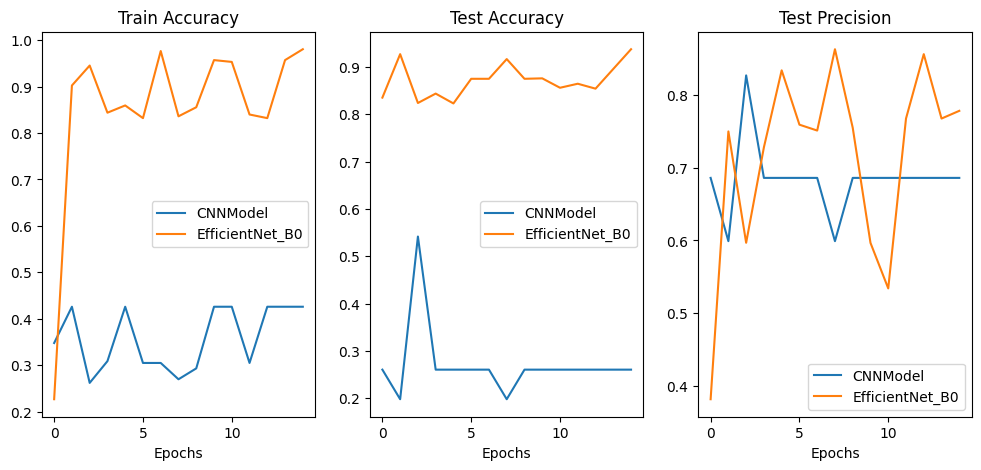

In [37]:
plot_loss_curves(model_1_results, results)

In [38]:
# Turn datasets into dataloader
import os
BATCH_SIZE = 8
NUM_WORKERS = os.cpu_count()
from torch.utils.data import DataLoader
torch.manual_seed(42)
train_dataloader_hybrid = DataLoader(train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=NUM_WORKERS)
test_dataloader_hybrid = DataLoader(test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                             num_workers=NUM_WORKERS)

In [39]:
# Check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader_hybrid))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([8, 3, 255, 255]), torch.Size([8]))

In [40]:
# create a flatten layer
flatten_model = nn.Flatten()

# Get a single sample
x = train_features_batch[0]

# Flatten the sample
output = flatten_model(x) # perform forward pass

# Print out what happened
print(f"Shape before flattening: {x.shape} -> [color_channels, height, width]")
print(f"Shape after flattening: {output.shape} -> [color_channels, height*width]")

Shape before flattening: torch.Size([3, 255, 255]) -> [color_channels, height, width]
Shape after flattening: torch.Size([3, 65025]) -> [color_channels, height*width]


In [41]:
import torch
import torch.nn as nn
from efficientnet_pytorch import EfficientNet

class HybridModel(nn.Module):
    def __init__(self, num_classes):
        super(HybridModel, self).__init__()

        # EfficientNetB0 as the backbone
        self.efficient_net = EfficientNet.from_pretrained('efficientnet-b0')

        # CNN layers
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=1280, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

        # Output layer
        self.output_layer = nn.Linear(in_features=(1280 + 1280)*49, out_features=num_classes)

    def forward(self, x):
        # EfficientNetB0 backbone
        features_efficient_net = self.efficient_net.extract_features(x)

        # CNN layers
        features_cnn = self.cnn_layers(x)

        # Resize CNN features to match EfficientNetB0 features
        features_cnn = nn.functional.adaptive_avg_pool2d(features_cnn, (7, 7))  # Adjust to match EfficientNetB0 feature size

        # Flatten features
        features_efficient_net = torch.flatten(features_efficient_net, 1)
        features_cnn = torch.flatten(features_cnn, 1)

        # Concatenate features from EfficientNetB0 and CNN
        features_concat = torch.cat((features_efficient_net, features_cnn), dim=1)

        # Classification
        output = self.output_layer(features_concat)

        return output

# Example usage:
# Define the number of classes
num_classes = 10  # Example number of classes
num_classes = num_classes

# Initialize the hybrid model
model_hybrid = HybridModel(num_classes)

# Example input tensor
input_tensor = torch.randn(1, 3, 255, 255)  # Example input shape (batch_size, channels, height, width)

# Forward pass
output = model_hybrid(input_tensor)
print("Output shape:", output.shape)


Loaded pretrained weights for efficientnet-b0
Output shape: torch.Size([1, 10])


In [42]:
# Define loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_hybrid.parameters(), lr=0.001)

In [43]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
results = train(model=model_hybrid,
                train_dataloader=train_dataloader_hybrid,
                test_dataloader=test_dataloader_hybrid,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=15,
                device=device)

# End the timer and print out how long it works
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 | Train_loss: 1.9792 | Train_acc: 0.6379 | Test_loss: 4.2634 | Test_acc: 0.6292 | Test_precision: 0.6583
Epoch: 2 | Train_loss: 1.0391 | Train_acc: 0.8362 | Test_loss: 2.8783 | Test_acc: 0.7542 | Test_precision: 0.6667
Epoch: 3 | Train_loss: 0.9209 | Train_acc: 0.8922 | Test_loss: 1.6145 | Test_acc: 0.8375 | Test_precision: 0.6833
Epoch: 4 | Train_loss: 0.8657 | Train_acc: 0.8922 | Test_loss: 1.1506 | Test_acc: 0.8500 | Test_precision: 0.6500
Epoch: 5 | Train_loss: 0.6745 | Train_acc: 0.8879 | Test_loss: 2.3926 | Test_acc: 0.7625 | Test_precision: 0.7619
Epoch: 6 | Train_loss: 0.9545 | Train_acc: 0.8836 | Test_loss: 1.9001 | Test_acc: 0.7500 | Test_precision: 0.6400
Epoch: 7 | Train_loss: 0.8662 | Train_acc: 0.8707 | Test_loss: 2.2993 | Test_acc: 0.7250 | Test_precision: 0.6438
Epoch: 8 | Train_loss: 1.1098 | Train_acc: 0.8405 | Test_loss: 2.1051 | Test_acc: 0.8000 | Test_precision: 0.5917
Epoch: 9 | Train_loss: 2.0114 | Train_acc: 0.8060 | Test_loss: 42.3192 | Test_acc: 0.245